<a href="https://colab.research.google.com/github/fractal2k/Learning-Deep-Learning/blob/master/torch_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

A vanillla GAN samples randomly from the normal distribution vector that we provide it. That aspect makes it unusable for practical applications.<br>The cGAN attempts to overcome that problem by conditioning the generator on labels of the output we want it to generate. Below is a very basic MNIST generator implementation.

## Necessary Imports

In [ ]:
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import torchvision

In [ ]:
BATCH_SIZE = 128
# FIXED_SIZE = 16  # 
Z_LEN = 100  # Noise vector length
BETA1 = 0.5  # Adam beta parameters
BETA2 = 0.999  # Adam beta parameters

## Dataset

In [ ]:
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Helper functions

In [ ]:
# Noise sampled from the standard normal distribution, input for the generator
def generate_noise(batch_size):
    return torch.randn(batch_size, Z_LEN, 1, 1, device=device)

In [ ]:
# The DCGAN paper says that all the weights must be randomly initialized with 
# mean=0 and stddev=0.02
# So, we create a custom function to initialize the weights of the network
def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def display_img(imgs, num_imgs):
    npimg = imgs.detach().numpy()
    npimg = npimg / 2 + 0.5
    fig = plt.figure(figsize=(4, 4))

    if num_imgs == 1:
        plt.imshow(npimg, cmap='gray')
        plt.axis('off')
    else:
        for i in range(num_imgs):
            plt.subplot(4, 4, i + 1)
            plt.imshow(npimg[i, :, :], cmap='gray')
            plt.axis('off')

    plt.show()

## Model Definition

In [ ]:
class ConditionalGenerator(nn.Module):
    r"""Generator of the CGAN setup
    """
    def __init__(self, input_dim, num_classes):
        super(ConditionalGenerator, self).__init__()

        # We use the embedding layer to convert the label into an embedding
        # of size z_len
        # TODO: Experiment with other manipulations for the label
        self.input_dim = input_dim
        self.embedding_layer = nn.Embedding(num_classes, input_dim)

        self.deconvolutions = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 512, 3, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Output: 3x3

            nn.ConvTranspose2d(512, 256, 3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output: 5x5

            nn.ConvTranspose2d(256, 128, 3, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output: 7x7

            nn.ConvTranspose2d(128, 64, 2, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Output: 14x14

            nn.ConvTranspose2d(64, 1, 2, stride=2, bias=False),
            nn.Tanh()
            # Output: 28x28
        )
    
    def forward(self, z, label):
        # Convert label into embedding and reshape into proper format for deconvolving
        embedding = torch.reshape(self.embedding_layer(label), (-1, self.input_dim, 1, 1))
        # Multiply input vector with embedding
        z = z * embedding

        return self.deconvolutions(z)

# Output from the network: (batch_size, channels, width, height)
# torch.squeeze() to get rid of the channels dimension (which is 1 in this case)

In [ ]:
class ConditionalDiscriminator(nn.Module):
    r"""Discriminator of the CGAN setup
    """
    def __init__(self, img_dim, num_classes):
        super(ConditionalDiscriminator, self).__init__()

        self.img_dim = img_dim

        # Convert the label into an embedding
        self.embedding_layer = nn.Embedding(num_classes, img_dim[0] * img_dim[1])

        self.convolutions = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 14x14

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 7x7

            nn.Conv2d(128, 128, 5, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 3x3

            nn.Conv2d(128, 1, 3, 1, 0, bias=False)
        )

    def forward(self, inp, label):
        # Create embedding of label
        embedding = self.embedding_layer(label)
        # Reshape embedding to size of input image
        embedding = torch.unsqueeze(torch.reshape(embedding, (-1, self.img_dim[1], self.img_dim[0])), 1)
        # Stack embedding on top of image
        inp = torch.cat((inp, embedding), axis=1)

        return self.convolutions(inp)

## Training

I use the Lookahead wrapper on Adam, I've found it to stabilize training

Lookahead optimizer implementation from [Michael Zhang's Github repo](https://github.com/michaelrzhang/lookahead/blob/master/lookahead_pytorch.py).

In [ ]:
class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(1.0 - self.la_alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [ ]:
NUM_CLASSES = 10
IMG_DIM = (28, 28)

# Initialize networks
gen = ConditionalGenerator(Z_LEN, NUM_CLASSES).to(device)
gen.apply(weights_initialization)

dis = ConditionalDiscriminator(IMG_DIM, NUM_CLASSES).to(device)
# I found it to work better without weight initialization
# dis.apply(weights_initialization)

In [ ]:
print(gen)
print(dis)

ConditionalGenerator(
  (embedding_layer): Embedding(10, 100)
  (deconvolutions): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): Tanh()
  )
)
ConditionalDiscriminator(
  (embedding_layer): Embedding(10, 784)
  (convolutions): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negat

In [ ]:
# Passing data through the network to check input and output shapes
for xbatch in trainloader:
    inps, lbls = xbatch
    inps = inps.to(device)
    lbls = lbls.to(device)
    xgen_inps = generate_noise(BATCH_SIZE)
    gout = gen(xgen_inps, lbls)
    dout = dis(inps, lbls)
    break

Input shape: torch.Size([128, 100, 1, 1])
Label shape: torch.Size([128])
Embedding shape: torch.Size([128, 100, 1, 1])
After multiplication: torch.Size([128, 100, 1, 1])
Input shape: torch.Size([128, 1, 28, 28])
Label shape: torch.Size([128])
Raw embedding shape: torch.Size([128, 784])
Embedding shape: torch.Size([128, 1, 28, 28])
Shape after stacking: torch.Size([128, 2, 28, 28])


In [ ]:
# Define loss criterion
criterion = nn.BCEWithLogitsLoss()

# Define optimizers
gen_opt = optim.Adam(gen.parameters(), lr=0.001, betas=(BETA1, BETA2))
gen_opt = Lookahead(optimizer=gen_opt, la_steps=10)

dis_opt = optim.Adam(dis.parameters(), lr=0.001, betas=(BETA1, BETA2))
dis_opt = Lookahead(optimizer=dis_opt, la_steps=10)

In [ ]:
EPOCHS = 100

# Training loop
# Yes, I dumped the entire training code inside the loop instead of making 
# a different function. Sue me.
for epoch in range(EPOCHS):
    gen_loss_list = []
    dis_loss_list = []
    for batch in trainloader:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Reset discriminator gradients
        dis_opt.zero_grad()

        # Train discriminator on real inputs
        real_outputs = dis(imgs, labels)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # Train discriminator on fake inputs
        gen_inputs = generate_noise(labels.shape[0])
        fake_inputs = gen(gen_inputs, labels)
        fake_outputs = dis(fake_inputs, labels)
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        total_dis_loss = real_loss + fake_loss
        dis_loss_list.append(total_dis_loss.detach().cpu().numpy())

        # Update discriminator parameters
        dis_opt.step()

        # Reset generator gradients
        gen_opt.zero_grad()

        # Train generator
        gen_inputs = generate_noise(BATCH_SIZE)
        gen_labels = torch.randint(0, 10, (BATCH_SIZE,)).to(device)
        dis_inputs = gen(gen_inputs, gen_labels)
        dis_outputs = dis(dis_inputs, gen_labels)
        dis_labels = torch.ones_like(dis_outputs)
        gen_loss = criterion(dis_outputs, dis_labels)
        gen_loss_list.append(gen_loss.detach().cpu().numpy())
        gen_loss.backward()

        # Update generator parameters
        gen_opt.step()
    
    # Print epoch details
    print(f'Epoch: {epoch}, Generator loss: {np.mean(gen_loss_list)}, Discriminator loss: {np.mean(dis_loss_list)}')

print('Finished training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Epoch: 0, Generator loss: 2.2236168384552, Discriminator loss: 0.9617975950241089
Epoch: 1, Generator loss: 0.8709059357643127, Discriminator loss: 1.3322042226791382
Epoch: 2, Generator loss: 0.7766062021255493, Discriminator loss: 1.3698444366455078
Epoch: 3, Generator loss: 0.7466338276863098, Discriminator loss: 1.3795934915542603
Epoch: 4, Generator loss: 0.7342373728752136, Discriminator loss: 1.3832719326019287
Epoch: 5, Generator loss: 0.7296650409698486, Discriminator loss: 1.3854501247406006
Epoch: 6, Generator loss: 0.722680926322937, Discriminator loss: 1.3851937055587769
Epoch: 7, Generator loss: 0.723686695098877, Discriminator loss: 1.385919213294983
Epoch: 8, Generator loss: 0.7244465947151184, Discriminator loss: 1.3853338956832886
Epoch: 9, Generator loss: 0.7237581610679626, Discriminator loss: 1.3860617876052856
Epoch: 10, Generator loss: 0.7217431664466858, Discriminator loss: 1.3853716850280762
Epoch: 11, Generator loss: 0.7221860289573669, Discriminator loss: 1.3

## Inference

In [ ]:
def generate_number(number):
    with torch.no_grad():
        pred_in = generate_noise(1)
        pred_lbl = torch.tensor([number], dtype=torch.long, device=device)
        generated = torch.squeeze(gen(pred_in, pred_lbl).detach().cpu())
        display_img(generated, 1)

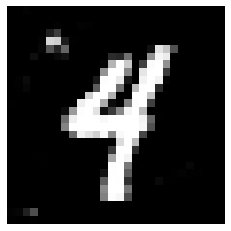

In [ ]:
generate_number(4)

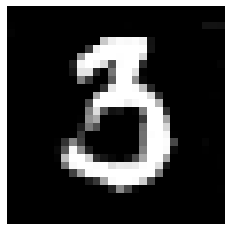

In [ ]:
generate_number(3)

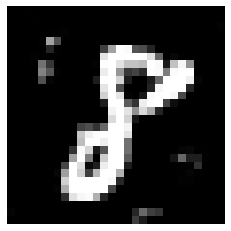

In [ ]:
generate_number(8)

In [ ]:
torch.save(gen.state_dict(), './cgan_gen_state_dict.pt')
torch.save(dis.state_dict(), './cgan_dis_state_dict.pt')

In [ ]:
# Loading saved model
Z_LEN = 100
NUM_CLASSES = 10

generator = ConditionalGenerator(Z_LEN, NUM_CLASSES)
generator.load_state_dict(torch.load('./cgan_gen_state_dict.pt', map_location=device))